# Определение возраста покупателей

## Исследовательский анализ данных

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Требуется построить модель, которая по фотографии определит приблизительный возраст человека. В распоряжении есть набор фотографий людей с указанием возраста.

**Описание данных:**

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/. 
В вашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: `file_name` и `real_age`. 

### Обзор данных

In [1]:
# перейдем в широкоформатный режим  Jupyter
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# импортируем необходимые библиотеки
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# начальное состояние генератора случайных чисел !!!!!!!!!!!!!! посмотри, нужен ли он тебе
RANDOM_STATE = 12345

In [4]:
# загрузим данные
labels = pd.read_csv('/datasets/faces/labels.csv')

train_datagen = ImageDataGenerator(rescale=1./255)

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=RANDOM_STATE) 

Found 7591 validated image filenames.


Выведем на экран произвольные 16 изображений из первого батча обучающей выборки:

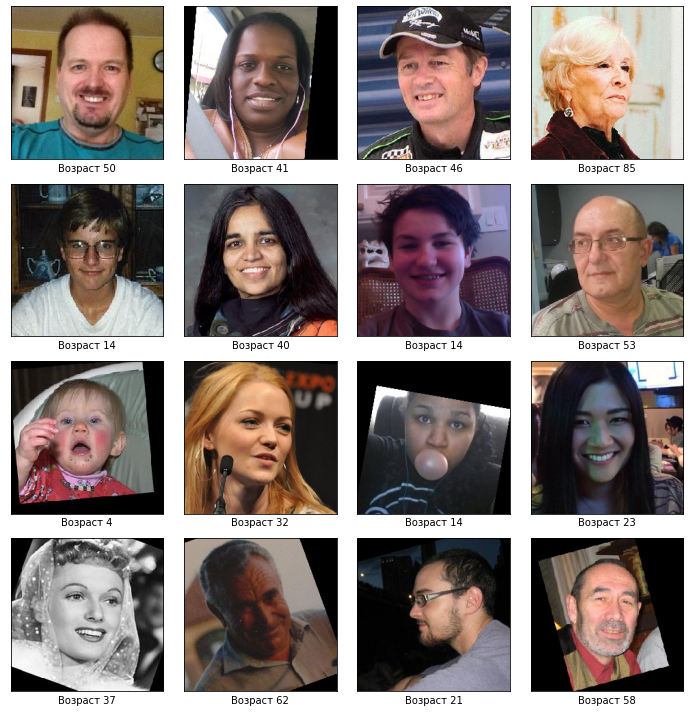

In [5]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xlabel(f'Возраст {target[i]}')
 # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


<div style="border:solid green 2px; padding: 20px">
    
* Всего представлено 7591 изображение.
* Заметим, что портреты уже отцентрированы и аугментация проведена, т.е. допольнительной предобработки изображений не требуется. 
* Возраст в целевом признаке выглядит похожим на реальный возраст. 
* Далее для предсказания модели так же потребуется подавать отцентрированные изображения, повернутые таким образом, чтобы лицо было вертикально.
    
</div>

### Анализ данных

Построим гистограмму распределения возраста в выборке

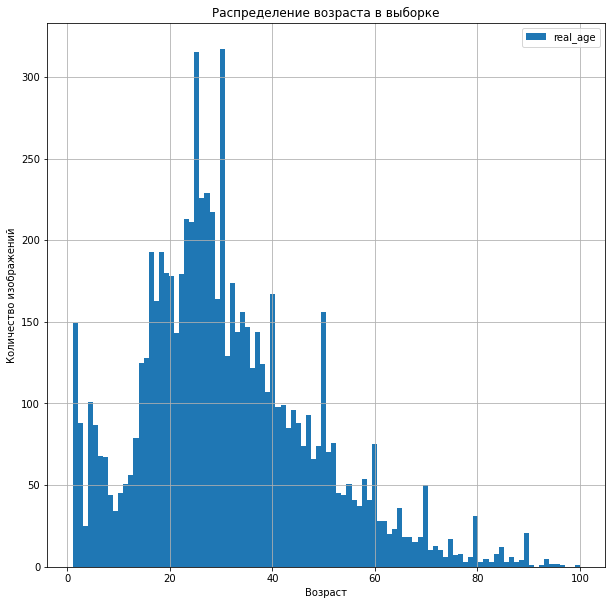

In [6]:
labels.plot(kind='hist', bins=100, figsize=(10,10), grid=True)
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.title('Распределение возраста в выборке')
plt.show()

<div style="border:solid green 2px; padding: 20px">

* Заметим, что наибольшее число изображений в промежутке от 20 до 33 лет, поэтому модель будет наиболее точно определять возраст в этом промежутке. 
* Также в промежутке от 30 до 90 лет заметим, что есть локальные пики в каждый десяток лет. Возможно, это связано с тем, что при разметке данных, если нет точного значения, возраст размечался примерно с точностью до 10 лет.
* Данные распределены по распределению Пуассона, также есть локальный пик детских изображений около 2 лет.
    
</div>

Выведем описание меток возраста:

In [7]:
display(labels.describe())

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


<div style="border:solid green 2px; padding: 20px">

* Заметим, что количество меток возраста соврадает с количеством изображений, т.е. в исходном датафрейме все изображения размечены.
* Минимальное значение возвраста 1 год, максимальное 100 лет, что вполне соответствует действительности.
    
</div>

## Обучение модели

Обучим модель, предсказывающую возвраст по фотографии. Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.

Для обучения мы выбрали модель ResNet50, предобученной на ImageNet, с решением задачи регрессии. В качестве функции потерь выбрали MSE, а метрикой выступила MAE. По заданию нужно было добиться значения MAE на тестовой выборке не больше 8. 

**Текстовое представление алгоритма:**

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import MeanSquaredError

import numpy as np
import pandas as pd

def load_train(path):

    datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1/255.)

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv('/datasets/faces/labels.csv'),
        directory='/datasets/faces/final_files',
        x_col='file_name',  # Имя столбца, содержащего имена файлов изображений
        y_col='real_age',  # Имя столбца, содержащего возраст
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

def load_test(path):

    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=pd.read_csv('/datasets/faces/labels.csv'),
        directory='/datasets/faces/final_files',
        x_col='file_name',  # Имя столбца, содержащего имена файлов изображений
        y_col='real_age',  # Имя столбца, содержащего возраст
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):

    model = Sequential()

    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model.add(backbone)

    model.add(GlobalAveragePooling2D())

    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss=MeanSquaredError(),
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=15,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

**Результат вывода модели при обучении:**

```

Train for 178 steps, validate for 60 steps
Epoch 1/15
178/178 - 65s - loss: 282.3433 - mae: 12.1831 - val_loss: 938.5210 - val_mae: 25.8343
Epoch 2/15
178/178 - 38s - loss: 103.5204 - mae: 7.6711 - val_loss: 518.1012 - val_mae: 17.2976
Epoch 3/15
178/178 - 38s - loss: 78.3705 - mae: 6.7032 - val_loss: 212.7295 - val_mae: 11.2440
Epoch 4/15
178/178 - 38s - loss: 65.2110 - mae: 6.0687 - val_loss: 125.2063 - val_mae: 8.4752
Epoch 5/15
178/178 - 38s - loss: 53.5602 - mae: 5.5467 - val_loss: 101.5340 - val_mae: 7.5861
Epoch 6/15
178/178 - 38s - loss: 43.9581 - mae: 5.0359 - val_loss: 111.9622 - val_mae: 7.6721
Epoch 7/15
178/178 - 39s - loss: 39.0878 - mae: 4.7477 - val_loss: 93.8189 - val_mae: 7.5263
Epoch 8/15
178/178 - 41s - loss: 32.0528 - mae: 4.2898 - val_loss: 72.0101 - val_mae: 6.3264
Epoch 9/15
178/178 - 42s - loss: 29.0070 - mae: 4.0903 - val_loss: 79.7423 - val_mae: 6.7147
Epoch 10/15
178/178 - 40s - loss: 26.4916 - mae: 3.9079 - val_loss: 79.2150 - val_mae: 6.5844
Epoch 11/15
178/178 - 40s - loss: 24.2074 - mae: 3.7746 - val_loss: 79.4498 - val_mae: 6.5075
Epoch 12/15
178/178 - 42s - loss: 21.1463 - mae: 3.5422 - val_loss: 85.1514 - val_mae: 7.1577
Epoch 13/15
178/178 - 42s - loss: 19.2979 - mae: 3.3432 - val_loss: 72.8529 - val_mae: 6.4700
Epoch 14/15
178/178 - 42s - loss: 16.8954 - mae: 3.1468 - val_loss: 69.3797 - val_mae: 6.3587
Epoch 15/15
178/178 - 49s - loss: 16.2273 - mae: 3.0833 - val_loss: 66.5526 - val_mae: 6.1365
60/60 - 11s - loss: 66.5526 - mae: 6.1365
Test MAE: 6.1365


```

## Анализ обученной модели

<div style="border:solid green 2px; padding: 20px">
    
* Полученная модель ResNet50 после обучения на 15 эпохах получила на тестовой выборке MAE = 6.13, что является отличным результатом. По требованию задачи нужно было получить модель с MAE не больше 8.
* Модель в среднем ошибается примерно на  лет, так что для определения возраста маленьких детей на снимках модель не очень подходит. Но так как модель нужна для определения возраста покупателей в супермаркете, для маленьких детей это не существенно.
* Наилучший результат был получен при learning_rate = 0.0001. При обучении так же на 15 эпохах с learning_rate = 0.001 MAE получился 8.64, а при learning_rate = 0.00001 MAE получился 7.19.
    
</div>

## Общие выводы

<div style="border:solid green 2px; padding: 20px">
    
* В проекте **требовалось построить модель для сетевого магазина, которая по фотографии определит приблизительный возраст человека**, чтобы анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, и контролировать добросовестность кассиров при продаже алкоголя.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
* Данные расположены в папке со всеми изображениями (/final_files) и CSV-файле labels.csv с двумя колонками: `file_name` и `real_age`. 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
* Всего было представлено 7591 изображение.
* Заметили, что портреты уже отцентрированы и аугментация проведена, т.е. допольнительной предобработки изображений не требуется. 
* Возраст в целевом признаке выглядит похожим на реальный возраст. Минимальное значение возвраста 1 год, максимальное 100 лет, что вполне соответствует действительности.
* Заметили, что количество меток возраста соврадает с количеством изображений, т.е. в исходном датафрейме все изображения размечены.
* **Далее для предсказания модели так же потребуется подавать отцентрированные изображения, повернутые таким образом, чтобы лицо было вертикально.**
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------   
* Заметили, что наибольшее число изображений в промежутке от 20 до 33 лет, поэтому модель будет наиболее точно определять возраст в этом промежутке. 
* Также в промежутке от 30 до 90 лет заметили, что есть локальные пики в каждый десяток лет. Возможно, это связано с тем, что при разметке данных, если нет точного значения, возраст размечался примерно с точностью до 10 лет.
* Данные распределены по распределению Пуассона, также есть локальный пик детских изображений около 2 лет.
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
* **Для обучения мы выбрали модель ResNet50, предобученной на ImageNet**, с решением задачи регрессии. В качестве функции потерь выбрали MSE, а метрикой выступила MAE. По заданию нужно было добиться значения MAE на тестовой выборке не больше 8. 
* **Полученная модель ResNet50 после обучения на 15 эпохах получила на тестовой выборке MAE = 6.13, что является отличным результатом.**
* **Модель в среднем ошибается примерно на 6 лет, так что для определения возраста маленьких детей на снимках модель не очень подходит.** Но так как модель нужна для определения возраста покупателей в супермаркете, для маленьких детей это не существенно.
* **Наилучший результат был получен при learning_rate = 0.0001.** При обучении так же на 15 эпохах с learning_rate = 0.001 MAE получился 8.64, а при learning_rate = 0.00001 MAE получился 7.19.
</div>